In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage


torch.backends.cudnn.benchmark=True

In [4]:
PATH = Path('data')
PATH_TRN = PATH/'train'

In [5]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

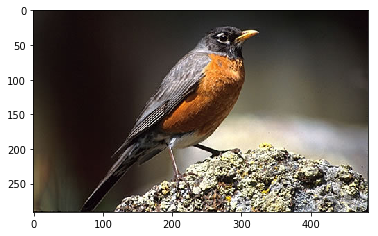

In [6]:
img_fn = PATH_TRN/'n01558993'/'n01558993_9684.JPEG'
img = open_image(img_fn)
plt.imshow(img);

In [7]:
sz = 288

In [8]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

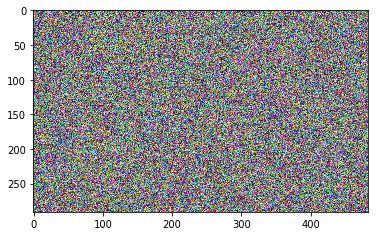

In [9]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [10]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

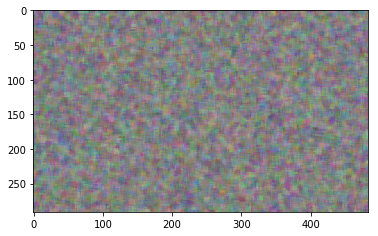

In [11]:
plt.imshow(opt_img);

In [12]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [13]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [14]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [15]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [16]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [17]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: n_iter, loss: {loss.data.cpu()[0]}')
    return loss

In [18]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step, actn_loss))

Iteration: n_iter, loss: 0.8286240696907043
Iteration: n_iter, loss: 0.35500410199165344
Iteration: n_iter, loss: 0.23025135695934296
Iteration: n_iter, loss: 0.17248713970184326
Iteration: n_iter, loss: 0.14125195145606995
Iteration: n_iter, loss: 0.12157535552978516
Iteration: n_iter, loss: 0.10797113925218582
Iteration: n_iter, loss: 0.09755974262952805
Iteration: n_iter, loss: 0.08976712077856064
Iteration: n_iter, loss: 0.0833887979388237


In [19]:
x = np.rollaxis(to_np(opt_img_v.data),1,4)


In [20]:
x.shape

(1, 288, 288, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


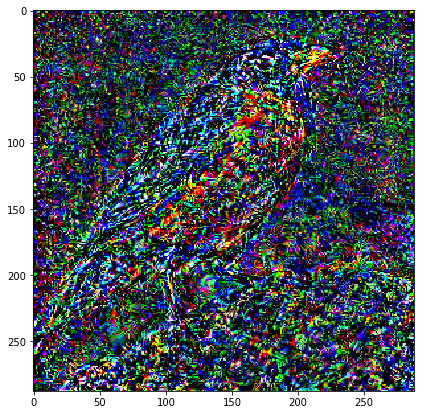

In [21]:
plt.figure(figsize=(7,7))
plt.imshow(x[0]);

In [22]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [23]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [24]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [25]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [26]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [27]:
opt_img_v, optimizer = get_opt()

In [28]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [29]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [31]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: n_iter, loss: 0.2288847267627716
Iteration: n_iter, loss: 0.09710561484098434
Iteration: n_iter, loss: 0.06335296481847763
Iteration: n_iter, loss: 0.04846765846014023
Iteration: n_iter, loss: 0.03989029675722122
Iteration: n_iter, loss: 0.03424263000488281
Iteration: n_iter, loss: 0.03012896329164505
Iteration: n_iter, loss: 0.02703825570642948
Iteration: n_iter, loss: 0.024669606238603592
Iteration: n_iter, loss: 0.022740518674254417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


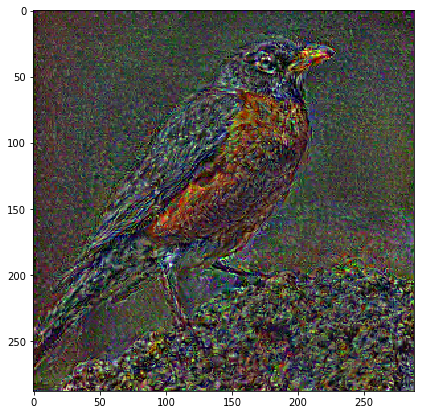

In [32]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [32]:
sf.close()

In [33]:
style_fn = PATH/'StarryNight.jpg'

In [34]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((900, 1136, 3), (291, 483, 3))

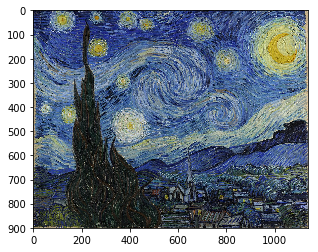

In [36]:
plt.imshow(style_img);

In [37]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh, w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h, :w]

In [38]:
style = scale_match(img, style_img)

((291, 483, 3), (291, 483, 3))

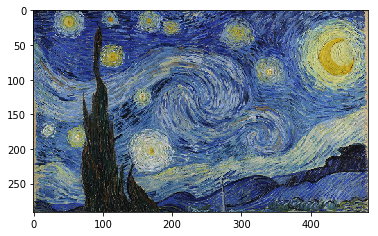

In [39]:
plt.imshow(style)
style.shape, img.shape

In [40]:
opt_img_v, optimizer = get_opt()

In [68]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [69]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [70]:
style_tfm = val_tfms(style_img)

In [44]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [45]:
def gram(input):
    b,c,h,w = input.size()
    x = input.view(b*c, -1)
    return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [46]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [48]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step, style_loss))

Iteration: n_iter, loss: 278.8668212890625
Iteration: n_iter, loss: 122.41171264648438
Iteration: n_iter, loss: 66.95628356933594
Iteration: n_iter, loss: 40.88764572143555
Iteration: n_iter, loss: 26.941226959228516
Iteration: n_iter, loss: 18.869707107543945
Iteration: n_iter, loss: 14.156044006347656
Iteration: n_iter, loss: 11.136855125427246
Iteration: n_iter, loss: 9.202436447143555
Iteration: n_iter, loss: 7.9592766761779785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


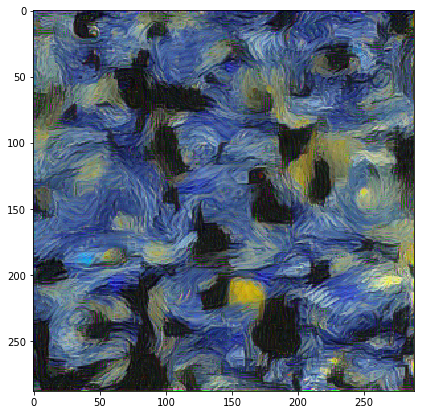

In [49]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [71]:
opt_img_v, optimizer = get_opt()

In [72]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [73]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: n_iter, loss: 1803.6485595703125
Iteration: n_iter, loss: 1205.4815673828125
Iteration: n_iter, loss: 1021.5411987304688
Iteration: n_iter, loss: 929.1516723632812
Iteration: n_iter, loss: 869.097900390625
Iteration: n_iter, loss: 829.441650390625
Iteration: n_iter, loss: 800.5433959960938
Iteration: n_iter, loss: 777.8199462890625
Iteration: n_iter, loss: 758.6041259765625
Iteration: n_iter, loss: 743.4794921875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


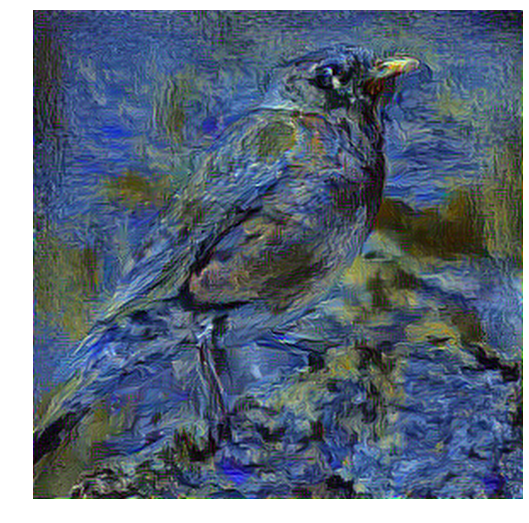

In [74]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');